In [7]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed
%matplotlib inline
sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    er = np.log10(np.abs(np.real(ztot)))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    er = np.log10(np.abs(np.real(ztot)))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L2_sigma(x):
    """
    Corrected version of Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    e = (((zr-np.real(ztot))**2) + ((zj-np.abs(np.imag(ztot)))**2)) / (zmag **2)
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))

    e = np.sum((np.abs((zr-np.real(ztot))))/(np.abs(zmag))) + \
        np.sum((np.abs((zj-np.abs(np.imag(ztot)))))/(np.abs(zmag)))

    L1 = e / n
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L2 Sigma")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.legend()
    plt.savefig('figs_sigma/' + title + 'rj_nolog.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L2 Sigma")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_sigma/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>-', label=r"L2 Sigma")
    plt.plot(f, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_sigma/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>-', label=r"L2 Sigma")
    plt.plot(f, zr_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_sigma/' + title + 'r.png', dpi=300, bbox_inches='tight')
    
    # residual plots
    plt.figure()
    plt.title(title)
    plt.plot(f, (zj-zj_l1)/zj, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zj-zj_l2)/zj, 's-', label='Log10 L2 norm')
    plt.plot(f, (zj-zj_linf)/zj, '>-', label=r"L2 Sigma")
    plt.plot(f, (zj-zj_lk)/zj, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_sigma/' + title + 'j_resid.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, (zr-zr_l1)/zr, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zr-zr_l2)/zr, 's-', label='Log10 L2 norm')
    plt.plot(f, (zr-zr_linf)/zr, '>-', label=r"L2 Sigma")
    plt.plot(f, (zr-zr_lk)/zr, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_sigma/' + title + 'r_resid.png', dpi=300, bbox_inches='tight')
    plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
#     solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=25,
#                              limits=bounds, minimize=True)
    solver = pyfde.JADE(obj_function, n_dim=5, n_pop=30,
                        limits=bounds, minimize=True)
    solver.c = np.random.random()
    solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()*2.0
#     # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
#     # polish with constrained nelder mead simplex optimization
#     res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
#                            full_output=True, xtol=1e-20, ftol=1e-20)
#     # if polish better save polish results
#     if res_cnm['fopt'] < fit:
#         opts = res_cnm['fopt']
#         results_x = res_cnm['xopt']
#         print('Polish was better')
#     else:
#         opts = fit
#         results_x = best
#         print('Polish did not help')
    res_bfgs = fmin_l_bfgs_b(obj_function, best, fprime=None, args=(), approx_grad=True,
                             bounds=bounds, m=10, factr=1.0, pgtol=1e-16,
                             epsilon=1e-05, iprint=-1, maxfun=15000, maxiter=15000, disp=None,
                             callback=None, maxls=20)
    # if polish better save polish results
    # print(best, fit)
    # print(res_bfgs)
    if res_bfgs[1] < fit:
        opts = res_bfgs[1]
        results_x = res_bfgs[0]
        print('Polish was better')
    else:
        opts = fit
        results_x = best            
        print('Polish did not help')
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=100, n_proc=8):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
#     print('Paramters:', results_x)
    print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Best Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


# Parasitic Capacitance Values for Wires
wire_c = 741.0e-12  # capacitance value measured for Autolab 



# Optimization 1
Jade, runs100, pop=30, bfgs

Optimization runtime 39.5219 seconds
Set of optima: [2.00941486e-14 1.79554149e-14 1.98099315e-14 1.84243731e-14
 2.00159889e-14 1.98241423e-14 9.73443548e-15 2.00515160e-14
 2.00053307e-14 1.98063788e-14 2.00941486e-14 2.00728323e-14
 1.77529103e-14 4.70388548e-01 2.00692796e-14 1.89004368e-14
 2.00159889e-14 1.99129602e-14 1.98596695e-14 1.99449346e-14
 1.99840144e-14 1.97921679e-14 2.01509920e-14 1.98703276e-14
 2.00301997e-14 1.97140082e-14 4.46409805e-09 2.41506367e-10
 1.93658423e-14 1.91562322e-14 2.00479633e-14 2.01119121e-14
 6.68054222e-01 1.74047443e-14 1.99200656e-14 1.88116189e-14
 1.98845385e-14 1.78346227e-14 2.00550687e-14 1.98099315e-14
 1.99733563e-14 2.02469153e-14 2.00266470e-14 1.97530881e-14
 1.99129602e-14 2.00941486e-14 2.00692796e-14 2.00479633e-14
 1.98880912e-14 2.00230943e-14 2.00479633e-14 2.00515160e-14
 1.99342765e-14 2.00550687e-14 2.00905959e-14 1.98916439e-14
 2.00159889e-14 1.98099315e-14 1.93445260e-14 1.83248972e-14
 0.00000000e+00 2.00017780e-14 2.

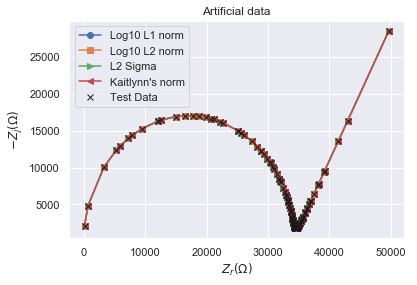

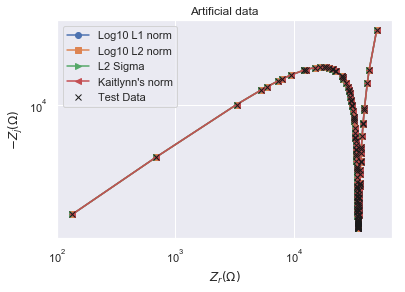

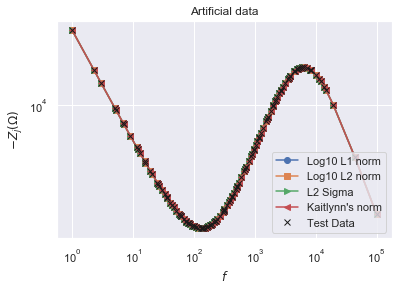

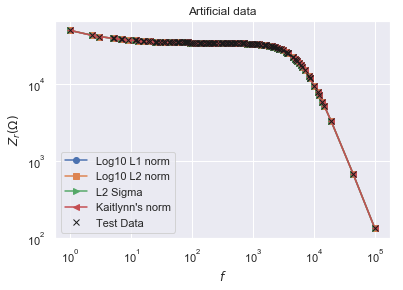

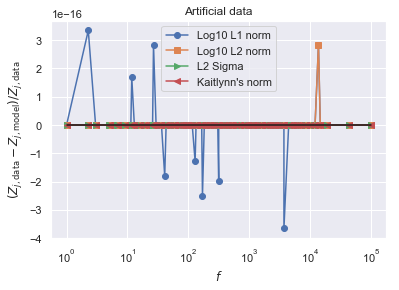

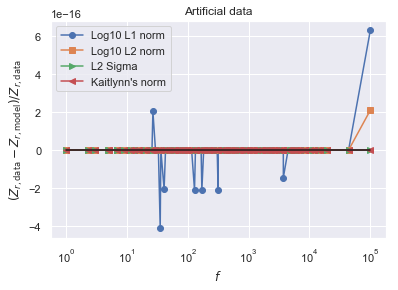

In [8]:
# optimization bounds
bounds = np.array(((1e-2, 1e1),
                  (1e-2, 1e1),
                  (1e0, 1e4),
                  (1e0, 1e4),
                  (1e0, 1e3)))

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L2_sigma)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
     'Artificial data')

# Optimization 2
lhs=100, bfgs

In [9]:
from pyDOE import lhs

def my_opt_fun2(obj_function, x):
    res_bfgs = fmin_l_bfgs_b(obj_function, x, fprime=None, args=(), approx_grad=True,
                             bounds=bounds, m=10, factr=1.0, pgtol=1e-16,
                             epsilon=1e-05, iprint=-1, maxfun=15000, maxiter=15000, disp=None,
                             callback=None, maxls=20)
    return np.append(res_bfgs[0], res_bfgs[1])


def opt_routine2(obj_function, runs=100, n_proc=8):
    """
    TBD
    """
    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun2)(obj_function, x) for x in lhd)  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
#     print('Paramters:', results_x)
    print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Best Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


Optimization runtime 1.1300 seconds
Set of optima: [4.84575653e-01 6.29935620e-06 3.17919746e+00 4.98909914e-01
 4.98904874e-01 4.98909963e-01 4.95114286e-01 4.98903663e-01
 4.98909968e-01 4.84575653e-01 3.62813913e-01 6.79840446e-06
 4.98908777e-01 4.46727063e-01 4.84575630e-01 3.69438735e-01
 4.98909966e-01 3.46794918e-01 3.62813905e-01 3.69428856e-01
 4.46727059e-01 7.08580058e-06 4.46714429e-01 4.95114357e-01
 4.98897912e-01 4.98909962e-01 4.98909968e-01 4.46727067e-01
 3.62384481e-01 4.98909950e-01 4.98909366e-01 4.95114334e-01
 4.98907602e-01 4.98909970e-01 4.98909826e-01 8.73347822e-06
 7.50023499e-06 8.11422574e-06 4.98899132e-01 4.98909964e-01
 4.98909827e-01 4.98904247e-01 1.04067397e-05 4.98909925e-01
 4.98909728e-01 4.13032111e-01 1.40574148e-01 8.70881618e-06
 4.98909937e-01 6.69720789e-06 4.46726946e-01 4.95114348e-01
 4.98865511e-01 5.91674008e-06 4.46727060e-01 6.88978926e-06
 3.59687805e-05 1.65022461e-05 4.98909812e-01 3.52980331e-01
 4.95114345e-01 3.67666015e-01 4.9

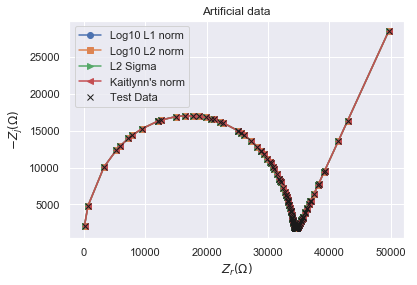

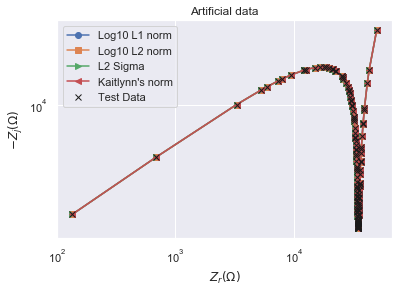

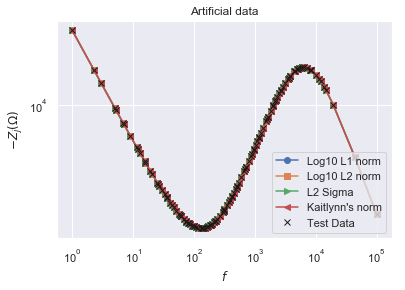

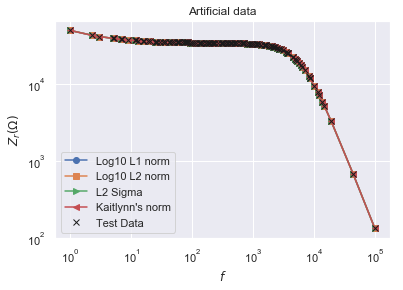

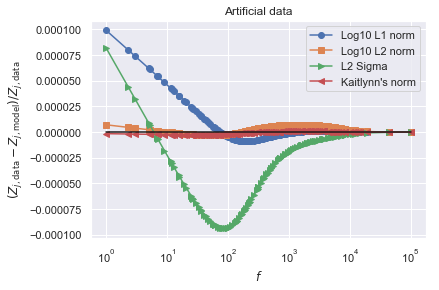

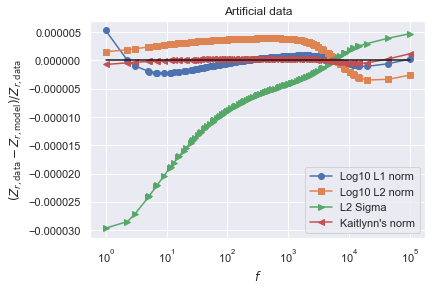

In [10]:
# optimization bounds
bounds = np.array(((1e-2, 1e1),
                  (1e-2, 1e1),
                  (1e0, 1e4),
                  (1e0, 1e4),
                  (1e0, 1e3)))
runs=100
# generate LHS DOE
lhd = lhs(5, samples=runs, criterion='maximin', iterations=int(1e3))
# convert lhd according to bounds
lb = np.repeat(bounds[:, 0], runs).reshape((5, runs)).T
ub = np.repeat(bounds[:, 1], runs).reshape((5, runs)).T    
lhd = (ub - lb) * lhd + lb

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine2(otto_model_L1_log, runs=runs)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine2(otto_model_L2_log, runs=runs)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine2(otto_model_L2_sigma, runs=runs)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine2(otto_model_L2_Kait, runs=runs)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
     'Artificial data')

# Optimization 2
lhs=10000, bfgs

lhd done
Optimization runtime 95.4054 seconds
Set of optima: [0.49890987 0.34679445 0.49890513 ... 0.21455538 0.41303214 0.49890971]
Best Objective value: 1.8968249137785166e-07
Best Paramters: [6.80000274e-01 8.79998268e+00 3.40000632e+01 2.14752268e+03
 6.21722479e+02] 



Optimization runtime 76.3971 seconds
Set of optima: [7.25667483e-01 7.55455908e-01 6.59664024e-01 ... 7.55456690e-01
 7.55456692e-01 1.66575053e-05]
Best Objective value: 2.6830720563935754e-07
Best Paramters: [6.79999978e-01 8.79999100e+00 3.40000686e+01 3.87624868e+03
 1.00000000e+03] 



Optimization runtime 57.0643 seconds
Set of optima: [3.43653754e-02 3.43653739e-02 1.35824882e-01 ... 6.23512587e-17
 6.75631278e-17 1.32830137e-01]
Best Objective value: 2.7702882757956866e-19
Best Paramters: [6.80019820e-01 8.79982436e+00 3.40002961e+01 4.10477931e+03
 6.71726111e+02] 



Optimization runtime 86.5421 seconds
Set of optima: [8.71607746e+07 3.67173030e+08 8.71607746e+07 ... 8.71607746e+07
 6.17519561e+07 6.17519

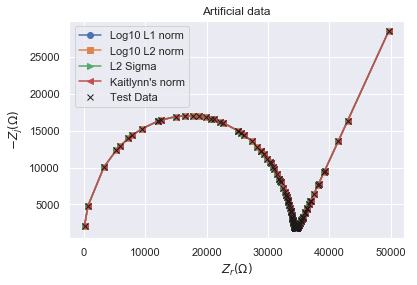

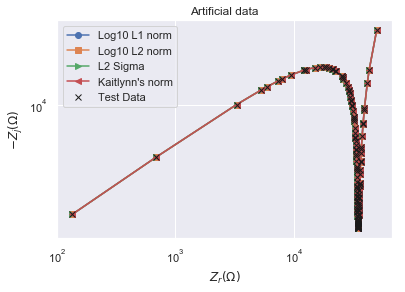

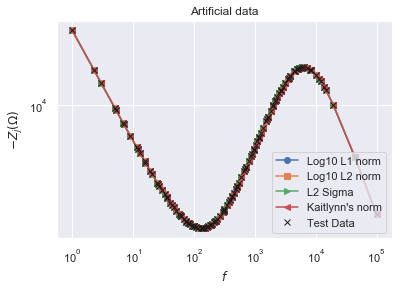

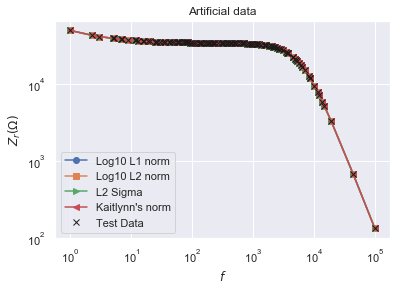

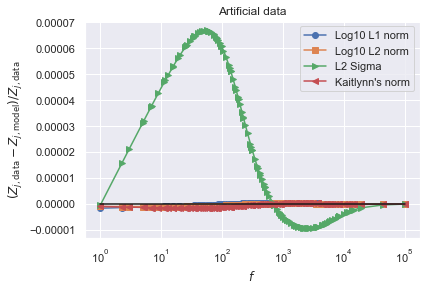

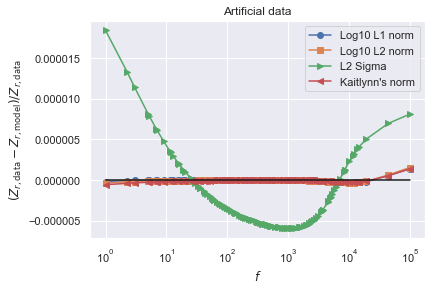

In [14]:
# optimization bounds
bounds = np.array(((1e-2, 1e1),
                  (1e-2, 1e1),
                  (1e0, 1e4),
                  (1e0, 1e4),
                  (1e0, 1e3)))
runs=10000
# generate LHS DOE
lhd = lhs(5, samples=runs, criterion='maximin', iterations=1)
print('lhd done')
# convert lhd according to bounds
lb = np.repeat(bounds[:, 0], runs).reshape((5, runs)).T
ub = np.repeat(bounds[:, 1], runs).reshape((5, runs)).T    
lhd = (ub - lb) * lhd + lb

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine2(otto_model_L1_log, runs=runs)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine2(otto_model_L2_log, runs=runs)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine2(otto_model_L2_sigma, runs=runs)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine2(otto_model_L2_Kait, runs=runs)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,'Artificial data')

# Optimization 3
random=10000, bfgs

Optimization runtime 93.9170 seconds
Set of optima: [0.49889436 0.49890995 0.49511433 ... 0.41303214 0.49890863 0.49890996]
Best Objective value: 1.1010345178164016e-07
Best Paramters: [6.80000114e-01 8.79999331e+00 3.40000092e+01 2.24349507e+03
 1.06386179e+02] 



Optimization runtime 69.2300 seconds
Set of optima: [7.25667480e-01 7.25667481e-01 1.83677036e-05 ... 5.92223040e-01
 7.55456691e-01 7.55456691e-01]
Best Objective value: 2.2774237032914808e-07
Best Paramters: [6.79999781e-01 8.80000015e+00 3.40000631e+01 7.67156131e+03
 5.99963618e+02] 



Optimization runtime 56.2418 seconds
Set of optima: [4.64382223e-02 1.35615485e-01 5.66669399e-16 ... 1.35824883e-01
 4.64382227e-02 4.64382227e-02]
Best Objective value: 6.437837540502708e-19
Best Paramters: [6.79971788e-01 8.80040232e+00 3.39997297e+01 2.54777757e+03
 3.92841276e+02] 



Optimization runtime 81.9744 seconds
Set of optima: [2.02617925e-10 4.14201173e-11 3.67173030e+08 ... 8.71607746e+07
 1.80085403e-10 3.57370998e+08]
B

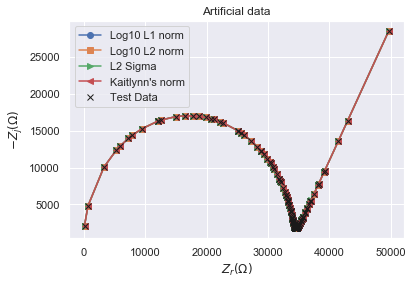

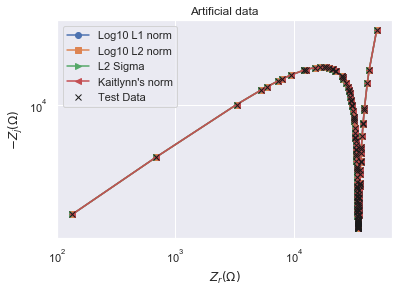

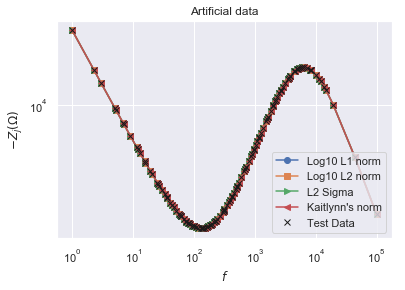

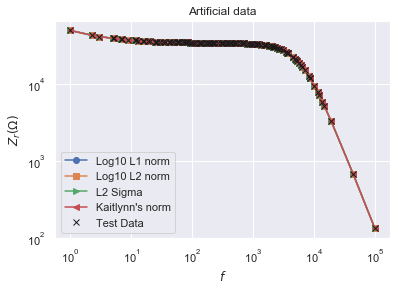

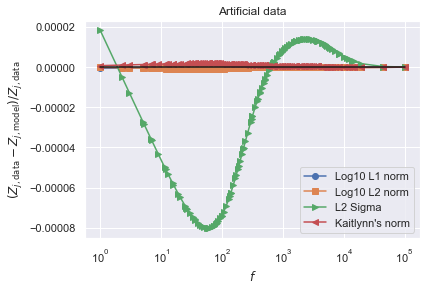

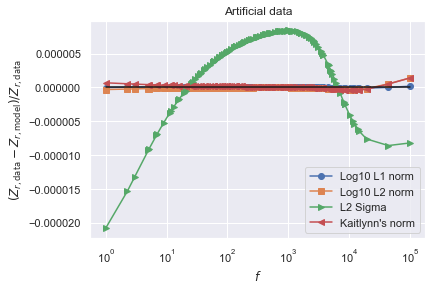

In [15]:
# optimization bounds
bounds = np.array(((1e-2, 1e1),
                  (1e-2, 1e1),
                  (1e0, 1e4),
                  (1e0, 1e4),
                  (1e0, 1e3)))
runs=10000
# generate LHS DOE
lhd = np.random.random(size=(runs, 5))
# convert lhd according to bounds
lb = np.repeat(bounds[:, 0], runs).reshape((5, runs)).T
ub = np.repeat(bounds[:, 1], runs).reshape((5, runs)).T    
lhd = (ub - lb) * lhd + lb

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine2(otto_model_L1_log, runs=runs)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine2(otto_model_L2_log, runs=runs)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine2(otto_model_L2_sigma, runs=runs)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine2(otto_model_L2_Kait, runs=runs)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,'Artificial data')